<a href="https://colab.research.google.com/github/tsai-praveen/tsai-assignments/blob/main/s5/S5_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary

# from model import Net, NormType

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [8]:
from enum import Enum

class NormType(Enum):
    BATCHNORM = 1
    LAYERNORM = 2
    GROUPNORM = 3

def get_norm_layer(norm_type: NormType, out_channels : int, ln_shape = None):
    norm_layer = None
    if norm_type == NormType.BATCHNORM:
        norm_layer = nn.BatchNorm2d(num_features=out_channels, affine=False)
    elif norm_type == NormType.LAYERNORM:
        norm_layer = nn.LayerNorm(normalized_shape=ln_shape, elementwise_affine=False)
    elif norm_type == NormType.GROUPNORM:
        num_groups = 2
        norm_layer = nn.GroupNorm(num_groups=num_groups, num_channels=out_channels, affine=False)

    return norm_layer

dropout_value = 0.1
class Net(nn.Module):
    @staticmethod
    def calc_activation_shape(inp_dim, ksize, dilation=(1, 1), stride=(1, 1), padding=(0, 0)):
        def shape_each_dim(i):
            odim_i = inp_dim[i] + 2 * padding[i] - dilation[i] * (ksize[i] - 1) - 1
            return int(odim_i / stride[i]) + 1

        return shape_each_dim(0), shape_each_dim(1)

    def __init__(self, norm_type : NormType):
        super(Net, self).__init__()

        # Input Block
        in_channels=1
        inp_dim = (28,28)
        out_channels=8
        kernel_size=(3, 3)
        conv_output_shape = Net.calc_activation_shape(inp_dim=inp_dim, ksize=kernel_size)
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_type=norm_type, out_channels=out_channels, ln_shape=[out_channels, *conv_output_shape]),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        in_channels = out_channels
        inp_dim = conv_output_shape
        out_channels=32
        kernel_size=(3, 3)
        conv_output_shape = Net.calc_activation_shape(inp_dim=inp_dim, ksize=kernel_size)
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False),
            nn.ReLU(),
            get_norm_layer(norm_type=norm_type, out_channels=out_channels, ln_shape=[out_channels, *conv_output_shape]),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        in_channels = out_channels
        inp_dim = conv_output_shape
        out_channels=10
        kernel_size=(1, 1)
        conv_output_shape = Net.calc_activation_shape(inp_dim=inp_dim, ksize=kernel_size)
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        in_channels = out_channels
        inp_dim = (conv_output_shape[0]//2, conv_output_shape[1]//2)
        out_channels=16
        kernel_size=(3, 3)
        conv_output_shape = Net.calc_activation_shape(inp_dim=inp_dim, ksize=kernel_size)
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False),
            nn.ReLU(),            
            get_norm_layer(norm_type=norm_type, out_channels=out_channels, ln_shape=[out_channels, *conv_output_shape]),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        in_channels = out_channels
        inp_dim = conv_output_shape
        out_channels=16
        kernel_size=(3, 3)
        conv_output_shape = Net.calc_activation_shape(inp_dim=inp_dim, ksize=kernel_size)
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False),
            nn.ReLU(),            
            get_norm_layer(norm_type=norm_type, out_channels=out_channels, ln_shape=[out_channels, *conv_output_shape]),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        in_channels = out_channels
        inp_dim = conv_output_shape
        out_channels=16
        kernel_size=(3, 3)
        conv_output_shape = Net.calc_activation_shape(inp_dim=inp_dim, ksize=kernel_size)
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False),
            nn.ReLU(),            
            get_norm_layer(norm_type=norm_type, out_channels=out_channels, ln_shape=[out_channels, *conv_output_shape]),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=conv_output_shape[0])
        ) # output_size = 1

        in_channels = out_channels
        out_channels=10
        kernel_size=(1, 1)
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False)
        ) 

        # self.dropout = nn.Dropout(dropout_value)

        # self.fc1 = nn.Linear(in_features=26, out_features=10, bias=False)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        # x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        # x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Group Normalization
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(norm_type=NormType.GROUPNORM).to(device)
print(summary(model, input_size=(1, 1, 28, 28)))

cuda
Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 26, 26]            --
│    └─Conv2d: 2-1                       [1, 8, 26, 26]            72
│    └─ReLU: 2-2                         [1, 8, 26, 26]            --
│    └─GroupNorm: 2-3                    [1, 8, 26, 26]            --
│    └─Dropout: 2-4                      [1, 8, 26, 26]            --
├─Sequential: 1-2                        [1, 32, 24, 24]           --
│    └─Conv2d: 2-5                       [1, 32, 24, 24]           2,304
│    └─ReLU: 2-6                         [1, 32, 24, 24]           --
│    └─GroupNorm: 2-7                    [1, 32, 24, 24]           --
│    └─Dropout: 2-8                      [1, 32, 24, 24]           --
├─Sequential: 1-3                        [1, 10, 24, 24]           --
│    └─Conv2d: 2-9                       [1, 10, 24, 24]           320
├─MaxP

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, l1_reg=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 1


Loss=0.17451535165309906 Batch_id=468 Accuracy=82.76: 100%|██████████| 469/469 [00:07<00:00, 61.05it/s] 



Test set: Average loss: 0.1477, Accuracy: 9694/10000 (96.94%)

EPOCH: 2


Loss=0.0909590944647789 Batch_id=468 Accuracy=96.44: 100%|██████████| 469/469 [00:07<00:00, 64.37it/s]  



Test set: Average loss: 0.0897, Accuracy: 9767/10000 (97.67%)

EPOCH: 3


Loss=0.059482391923666 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:07<00:00, 65.33it/s]    



Test set: Average loss: 0.0613, Accuracy: 9822/10000 (98.22%)

EPOCH: 4


Loss=0.07022865861654282 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:07<00:00, 64.68it/s]  



Test set: Average loss: 0.0494, Accuracy: 9870/10000 (98.70%)

EPOCH: 5


Loss=0.06475905328989029 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:07<00:00, 65.50it/s]  



Test set: Average loss: 0.0390, Accuracy: 9893/10000 (98.93%)

EPOCH: 6


Loss=0.01609484665095806 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:07<00:00, 64.74it/s]  



Test set: Average loss: 0.0450, Accuracy: 9887/10000 (98.87%)

EPOCH: 7


Loss=0.06727053970098495 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:07<00:00, 65.76it/s]  



Test set: Average loss: 0.0368, Accuracy: 9896/10000 (98.96%)

EPOCH: 8


Loss=0.02858058363199234 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:07<00:00, 64.63it/s]  



Test set: Average loss: 0.0343, Accuracy: 9903/10000 (99.03%)

EPOCH: 9


Loss=0.07891043275594711 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:07<00:00, 64.60it/s]  



Test set: Average loss: 0.0371, Accuracy: 9892/10000 (98.92%)

EPOCH: 10


Loss=0.014952932484447956 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:07<00:00, 64.62it/s] 



Test set: Average loss: 0.0333, Accuracy: 9898/10000 (98.98%)

EPOCH: 11


Loss=0.048340216279029846 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:07<00:00, 64.15it/s] 



Test set: Average loss: 0.0320, Accuracy: 9898/10000 (98.98%)

EPOCH: 12


Loss=0.009630227461457253 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:07<00:00, 65.30it/s] 



Test set: Average loss: 0.0275, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.04639345780014992 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:07<00:00, 65.27it/s]  



Test set: Average loss: 0.0285, Accuracy: 9910/10000 (99.10%)

EPOCH: 14


Loss=0.0243693757802248 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:07<00:00, 64.30it/s]   



Test set: Average loss: 0.0338, Accuracy: 9892/10000 (98.92%)

EPOCH: 15


Loss=0.06411883980035782 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:07<00:00, 64.88it/s]  



Test set: Average loss: 0.0282, Accuracy: 9920/10000 (99.20%)

EPOCH: 16


Loss=0.018470846116542816 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:07<00:00, 64.92it/s] 



Test set: Average loss: 0.0267, Accuracy: 9914/10000 (99.14%)

EPOCH: 17


Loss=0.08246376365423203 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:07<00:00, 64.82it/s] 



Test set: Average loss: 0.0279, Accuracy: 9905/10000 (99.05%)

EPOCH: 18


Loss=0.058438386768102646 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:07<00:00, 62.12it/s] 



Test set: Average loss: 0.0274, Accuracy: 9922/10000 (99.22%)

EPOCH: 19


Loss=0.014159668236970901 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:08<00:00, 58.24it/s]



Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.03559126704931259 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:07<00:00, 64.35it/s]  



Test set: Average loss: 0.0267, Accuracy: 9917/10000 (99.17%)



In [ ]:
# import necessary libraries
import matplotlib.pyplot as plt

# define a function to plot misclassified images
def plot_misclassified_images(model, test_loader):
    # set model to evaluation mode
    model.eval()

    misclassified_images = []
    actual_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    misclassified_images.append(data[i])
                    actual_labels.append(target[i])
                    predicted_labels.append(pred[i])

    # Plot the misclassified images
    fig = plt.figure(figsize=(10, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        plt.imshow(misclassified_images[i].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()


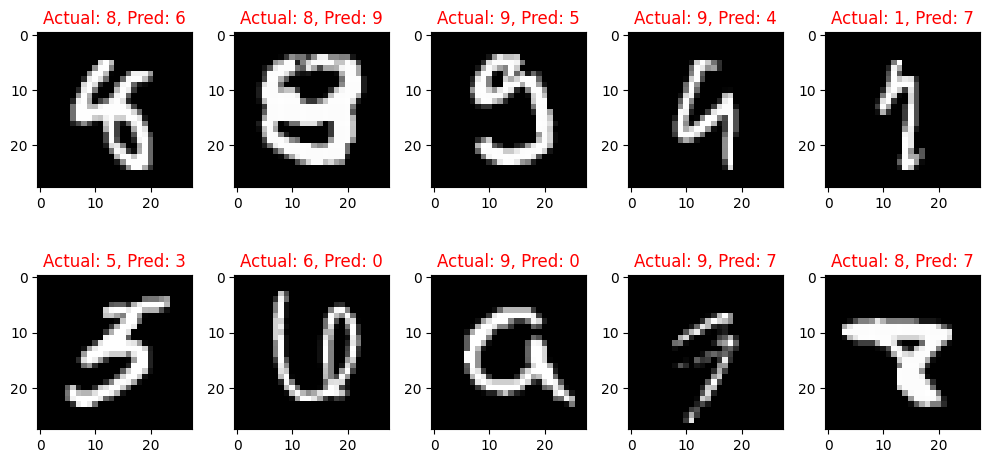

In [17]:
plot_misclassified_images(model, test_loader)

# Let's Train and test our model

This time let's add a scheduler for out LR. 

In [13]:
tr_losses = [x.cpu().item() for x in train_losses]


Text(0.5, 1.0, 'Test Accuracy')

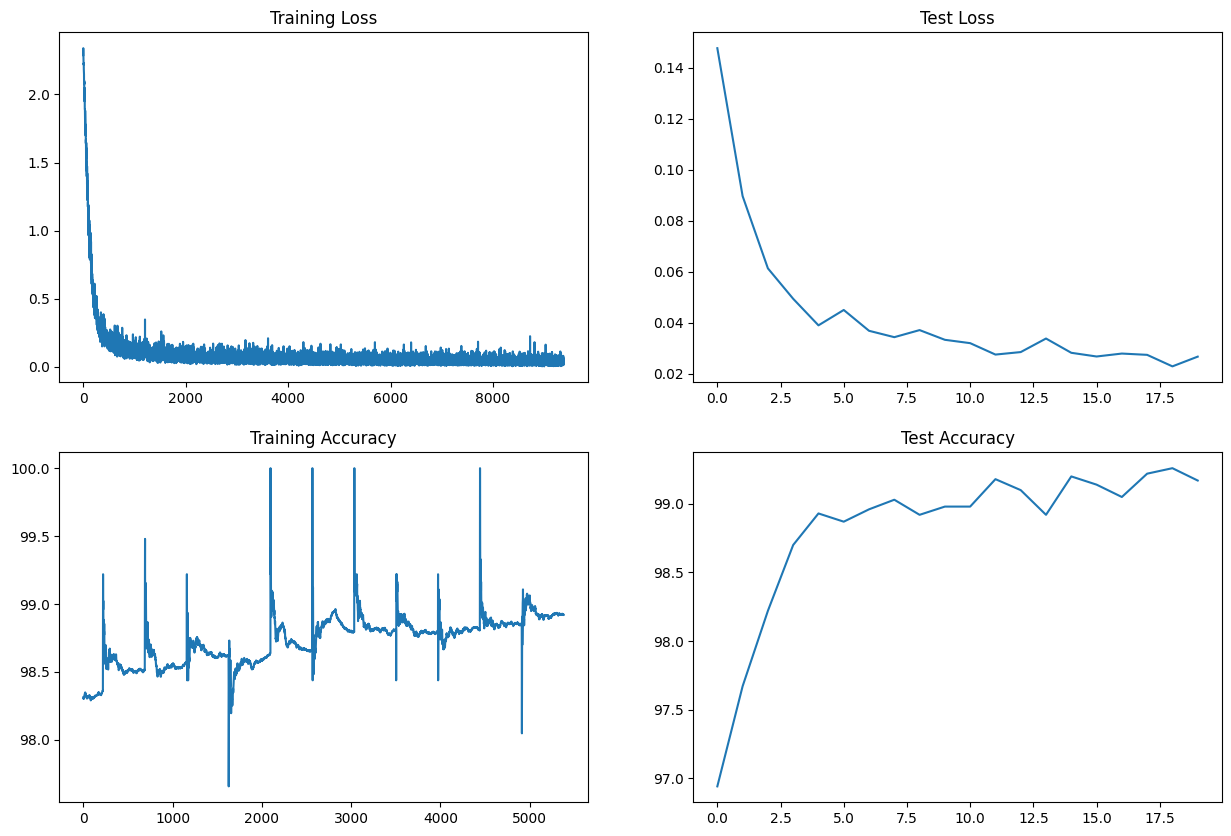

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(tr_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")